## Imports Useful Libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
from numpy import linalg as LA
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
import time
from datetime import timedelta

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from mnist import MNIST
data = MNIST(data_dir="data/MNIST/")

## Copy some of the data-dimensions for convenience.
img_size_flat is the number of pixels in an image when the image is flattened, img_size_flat = 28 * 28 = 784.

img_shape is the shape of an image in 2-D, img_shape = 28 * 28 (28 by 28).

num_classes is the number of output classes for the images, num_classes = 10

In [3]:
img_size_flat = data.img_size_flat
img_shape = data.img_shape
num_classes = data.num_classes

## Define the placeholders for feeding the training and testing data to the computational graph
x is a placeholder variable whose dimensions are [None, img_size_flat] through which the images are fed to the model for training as well as testing.

y_true is the placeholder through which the correct class for a training or testing data is fed to the network.

In [4]:
x = tf.placeholder(tf.float32, [None, img_size_flat])
y_true = tf.placeholder(tf.float32, [None, num_classes]) # y_true is a one-hot vector of class labels
y_true_cls = tf.argmax(y_true, axis =1) # not a placeholder, y_true cls contains the class label as an integral value

## Define the dimensions of the model
Our model is a multi-layer perceptron with 4 hidden layers having 1000, 1000, 500 and 200 neurons respectively. For ease of simplicity, biases are not used in the model.

In [5]:
hidden1 = 1000
hidden2 = 1000
hidden3 = 500
hidden4 = 200

## Variables to be optimized
w1-w5 are 5 trainable variables that will be optimized during the training.

In [6]:
w1 = tf.Variable(tf.truncated_normal([img_size_flat,hidden1], stddev = 0.05, seed=25))
h1 = tf.nn.relu(tf.matmul(x,w1))

w2 = tf.Variable(tf.truncated_normal([hidden1,hidden2],stddev = 0.05, seed=25))
h2 = tf.nn.relu(tf.matmul(h1,w2))

w3 = tf.Variable(tf.truncated_normal([hidden2,hidden3], stddev = 0.05, seed=25))
h3 = tf.nn.relu(tf.matmul(h2,w3))

w4 = tf.Variable(tf.truncated_normal([hidden3,hidden4],stddev = 0.05, seed=25))
h4 = tf.nn.relu(tf.matmul(h3,w4))

w5 = tf.Variable(tf.truncated_normal([hidden4,num_classes], stddev = 0.05, seed=25))
logits = tf.matmul(h4,w5)

y_pred = tf.nn.softmax(logits)

y_pred_cls = tf.argmax(y_pred, axis=1)

## Calculation of model loss
To understand and quantify the performance of the model, a cross-entropy loss is defined over the oputput of the model and true class values.

In [7]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=y_true)
cost = tf.reduce_mean(cross_entropy)

## Define optimization and accuracy operation

In [8]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Create a tensorflow session and initialize all the variables

In [9]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [10]:
batch_size = 100

## Define a function for carrying out num_iterations iterations to train the model

In [11]:
def optimize(optimizer, num_iterations):
    #start_time = time.time()
        
    for i in range(num_iterations):
        x_batch, y_true_batch, _ = data.random_batch(batch_size=batch_size)
        feed_dict_train = {x: x_batch,y_true: y_true_batch}
        session.run(optimizer, feed_dict=feed_dict_train)
        
    #end_time = time.time()
    #time_dif = end_time - start_time
    #print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [12]:
feed_dict_test = {x: data.x_test,
                  y_true: data.y_test,
                  y_true_cls: data.y_test_cls}

## Define a function to calculate and print the accuracy over the test set

In [13]:
def print_accuracy():
    
    start_time = time.time()
    acc = session.run(accuracy, feed_dict=feed_dict_test)    
    end_time = time.time()
    
    timedelta = (end_time-start_time)*1000
    
    print("Accuracy on test-set: {0:.1%}".format(acc))
    print("Execution time in milliseconds: {0:.4}".format(timedelta))
    
    return acc*100, timedelta

## Performance after 2000 optimization iterations

In [14]:
optimize(optimizer, num_iterations = 2000)

In [15]:
original_accuracy, exec_time = print_accuracy()

Accuracy on test-set: 97.4%
Execution time in milliseconds: 562.8


# Increasing the speed of execution of the neural net using neuron pruning

Henceforth, whenever we say "smaller network", we mean neuron pruned network from which k% neurons in each hidden layer(except the ;ast layer) have been deleted.

In [16]:
sparsity = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]

In [17]:
def execution_speed(sparsity, num_iterations):
    
    acc_before_retraining = []
    execution_time_before_retraining = []
    acc_after_retraining = []
    execution_time_after_retraining = []
    
    for k in sparsity:
        
        # Convert the weights of the trained model to numpy arrays for pre-processing.
        wt1 = np.asarray(session.run(w1))
        wt2 = np.asarray(session.run(w2))
        wt3 = np.asarray(session.run(w3))
        wt4 = np.asarray(session.run(w4))
        wt5 = np.asarray(session.run(w5))

        # Find the norm of each column (each column corresponds to a neuron in the next layer) in each weight matrix.
        norm1 = LA.norm(wt1, axis=0)
        norm2 = LA.norm(wt2, axis=0)
        norm3 = LA.norm(wt3, axis=0)
        norm4 = LA.norm(wt4, axis=0)
        
        # Set the weights for lower k% norms to 0. This renders k% neurons in each hidden layer passive.
        # The connections from last hidden layer to the output layer have been left as it is.
        
        wt1[:,np.argwhere(norm1<np.percentile(norm1,k))] = 0
        wt2[:,np.argwhere(norm2<np.percentile(norm2,k))] = 0
        wt3[:,np.argwhere(norm3<np.percentile(norm3,k))] = 0
        wt4[:,np.argwhere(norm4<np.percentile(norm4,k))] = 0

        ### Now, even though we have made k% neurons in each hidden layer passive by setting the 
        # weights corresponding to their connections in the previous layer as 0, these neurons still 
        # participate in matrix multiplication. Thus, we have introduced sparsity in our network, but
        # have not made the size of yhe network smaller.
        
        # To make our network smaller in size, we need to delete these k% neurons.
        # This gets tricky here, so pay close attention.
        
        # Here, take note of these 2 important points:
        
        # i) When we delete a row from a weight matrix, a neuron in the same layer is deleted.
        # ii) When we delete a column from a weight matrix, a neuron in the
        # next layer is deleted.
        
        # e.g: Let w3 be the weight matrix that connects hidden layer 2(1000 neurons) to hidden layer 3(500 neurons).
        # On deleting 4th row from w3, the 4th neuron in hidden layer 2 is deleted.
        # Similarly, on deleting 6th column from w3, the 6th neuron in hidden layer 3 is deleted.
          
        # columns with norm = 0 in wt1(connects input layer to hidden layer 1)
        # Here, we must not delete neurons in the inout layer.
        index1 = np.argwhere(wt1[0,:]==0) # indices of columns for which norm = 0
        wt1 = np.delete(wt1,index1,axis=1) # delete columns with norm = 0
        
        
        # columns with norm = 0 in wt2(connects hidden layer 1 to hidden layer 2)
        index2 = np.argwhere(wt2[0,:]==0)
        
        # delete rows with index same as columns deleted in wt1
        wt2 = np.delete(wt2,index1,axis=0) #axis=0 means delete rows
        wt2 = np.delete(wt2,index2,axis=1) #axis=1 means delete column
        
        index3 = np.argwhere(wt3[0,:]==0)
        wt3 = np.delete(wt3,index2,axis=0)
        wt3 = np.delete(wt3,index3,axis=1)
        
        wt4 = np.delete(wt4,index3,axis=0)        
        
        ############################################################
        
        # Define the architecture of the neural network.
        
        wt1 = tf.Variable(tf.convert_to_tensor(wt1))
        ht1 = tf.nn.relu(tf.matmul(x,wt1))

        wt2 = tf.Variable(tf.convert_to_tensor(wt2))
        ht2 = tf.nn.relu(tf.matmul(ht1,wt2))

        wt3 = tf.Variable(tf.convert_to_tensor(wt3))
        ht3 = tf.nn.relu(tf.matmul(ht2,wt3))

        wt4 = tf.Variable(tf.convert_to_tensor(wt4))
        ht4 = tf.nn.relu(tf.matmul(ht3,wt4))

        wt5 = tf.Variable(tf.convert_to_tensor(wt5))
        logits = tf.matmul(ht4,wt5)
    
        y_pred = tf.nn.softmax(logits)
        y_pred_cls = tf.argmax(y_pred, axis=1)
        
        ###############################################################
        
        # Now, we perform 2 types of analyses:
        
        # i) Calculate the accuracy and execution time with the smaller network before it is retrained
        # So, we just delete the k% neurons in each layer(thus making the network smaller) and 
        # calculate the accuracy on the test set without retraining this smaller model.
        
        # ii) Same operation as in (i) but after training the smaller neural network again
        
        # Add a node to calculate accuracy before retraining of the neural network. Here, we only define these 
        # operations, no calculation is performed at this stage.
        correct_prediction_before_retraining = tf.equal(y_pred_cls, y_true_cls)
        accuracy_before_retraining = tf.reduce_mean(tf.cast(correct_prediction_before_retraining, tf.float32))
        
        
        # Add a node to calculate the cross entropy and cost value to be passed to optimizer for retraining 
        # of the network. 
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=y_true)
        cost = tf.reduce_mean(cross_entropy)
        
        # Define the optimization operation
        optimizer_np = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)
        
        # Add a node to calculate the accuracy after retraining of the neural network.
        correct_prediction_after_retraining = tf.equal(y_pred_cls, y_true_cls)
        accuracy_after_retraining = tf.reduce_mean(tf.cast(correct_prediction_after_retraining, tf.float32))
        
        # Initialize the weights of the smaller neural network
        session.run(wt1.initializer)
        session.run(wt2.initializer)
        session.run(wt3.initializer)
        session.run(wt4.initializer)
        session.run(wt5.initializer)
        
        # Calculate accuracy before training and the time required for the execution of this operation
        start_time_1 = time.time()
        acc1 = session.run(accuracy_before_retraining, feed_dict = feed_dict_test)
        duration_1 = time.time() - start_time_1
        acc_before_retraining.append(acc1*100)
        execution_time_before_retraining.append(duration_1*1000)
        
        # Retrain the smaller neural network by running the optimization operation by calling the 
        # optimize function (defined above)
        optimize(optimizer_np, num_iterations)
    
        # Calculate accuracy after training and the time required for the execution of this operation
        start_time_2 = time.time()
        acc2 = session.run(accuracy_after_retraining, feed_dict = feed_dict_test)
        duration_2 = time.time() - start_time_2
        acc_after_retraining.append(acc2*100)
        execution_time_after_retraining.append(duration_2*1000)
        
        
    return (acc_before_retraining, execution_time_before_retraining,
            acc_after_retraining, execution_time_after_retraining)

In [18]:
acc_before_retraining, exec_time_before_retraining,acc_after_retraining, exec_time_after_retraining \
= execution_speed(sparsity, 1000)

# Analysis of accuracy and execution time for the smaller network (k% neurons in each hidden layer except the last hidden layer are deleted)

Plot 1: Percentage sparsity vs percentage accuracy shows that the accuracy of the network decreases as more and more of it is pruned. However, on retraining, it is able to recover the accuracy considerably. Plot 2: Percentage sparsity vs execution time on the test set shows that both the smaller networks: one before the smaller network is retrained and other after the smaller network is retrained take almost the same time in execution on the test set.


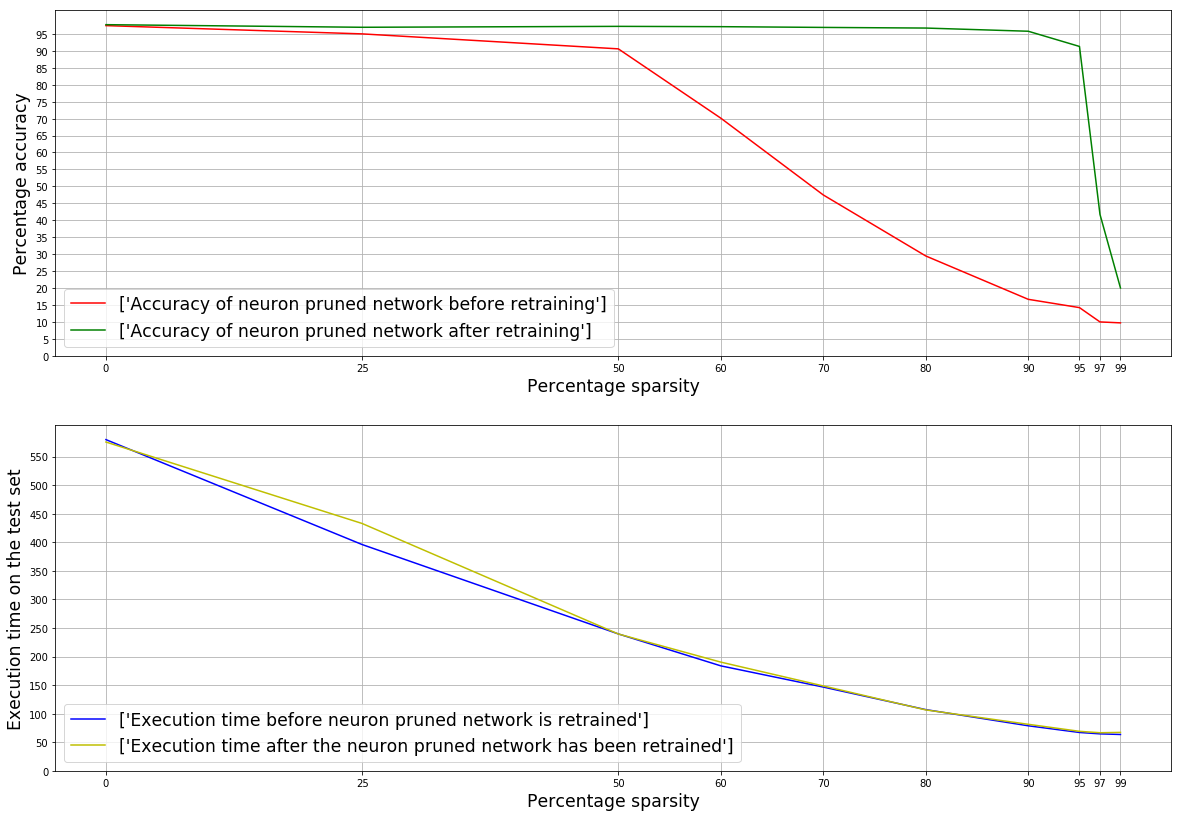

In [19]:
print('Plot 1: Percentage sparsity vs percentage accuracy shows that the accuracy of the network decreases \
as more and more of it is pruned. However, on retraining, it is able to recover the accuracy considerably.\
\
 Plot 2: Percentage sparsity vs execution time on the test set shows that both the smaller networks: \
one before the smaller network is retrained and other after the smaller network is retrained \
take almost the same time in execution on the test set.')

fig = plt.figure(figsize=(20,14))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(sparsity,acc_before_retraining,'r', sparsity,acc_after_retraining,'g')
ax1.grid()
ax1.legend([['Accuracy of neuron pruned network before retraining'],
            ['Accuracy of neuron pruned network after retraining']],
           loc='lower left', fontsize='xx-large')

ax1.set_xlabel('Percentage sparsity',fontsize='xx-large')
ax1.set_ylabel('Percentage accuracy',fontsize='xx-large')
ax1.set_xticks(sparsity)
ax1.set_yticks(np.arange(0,100,5))


ax2.plot(sparsity, exec_time_before_retraining,'b', sparsity,exec_time_after_retraining,'y')
ax2.grid()
ax2.legend([['Execution time before neuron pruned network is retrained'],
            ['Execution time after the neuron pruned network has been retrained']],
           loc='lower left', fontsize='xx-large')
ax2.set_xlabel('Percentage sparsity',fontsize='xx-large')
ax2.set_ylabel('Execution time on the test set',fontsize='xx-large')
ax2.set_xticks(sparsity)
ax2.set_yticks(np.arange(0,exec_time_before_retraining[0],50))

plt.show()

# Now, let us observe the decrease in accuracy of the smaller network and speedup of the execution time as sparsity is increased.

In [20]:
speedup_1=[1]
for i in range(len(exec_time_before_retraining)-1):
    temp = exec_time_before_retraining[0]/exec_time_before_retraining[i+1]
    speedup_1.append(temp)
    
    
accuracy_decrease_1 = [0]

for i in range(len(acc_before_retraining)-1):
    temp = acc_before_retraining[0]-acc_before_retraining[i+1]
    accuracy_decrease_1.append(temp)

In [21]:
speedup_2=[1]
for i in range(len(exec_time_after_retraining)-1):
    temp = exec_time_after_retraining[0]/exec_time_after_retraining[i+1]
    speedup_2.append(temp)
    
accuracy_decrease_2 = [0]

for i in range(len(acc_after_retraining)-1):
    temp = acc_after_retraining[0]-acc_after_retraining[i+1]
    accuracy_decrease_2.append(temp)

In [22]:
data1 = np.array([sparsity, acc_before_retraining, accuracy_decrease_1 , speedup_1])
df1 = pd.DataFrame(data1.T, columns=['% Sparsity','Accuarcy of neuron pruned smaller network before retraining(%)',\
                                    'Decrease in accuracy(%)','Execution time speedup, times X'])
df1.style.set_properties(**{'text-align': 'center'})
display(df1)

data2 = np.array([sparsity, acc_after_retraining, accuracy_decrease_2 , speedup_2])
df2 = pd.DataFrame(data2.T, columns=['% Sparsity','Accuarcy of neuron pruned smaller network after retraining(%)',\
                                    'Decrease in accuracy(%)','Execution time speedup, times X'])
df2.style.set_properties(**{'text-align': 'center'})
display(df2)

,% Sparsity,Accuarcy of neuron pruned smaller network before retraining(%),Decrease in accuracy(%),"Execution time speedup, times X"
0,0.0,97.439998,0.000000,1.000000
1,25.0,94.999999,2.440000,1.463724
2,50.0,90.579998,6.860000,2.419528
3,60.0,70.120001,27.319998,3.155736
4,70.0,47.450000,49.989998,3.955249
5,80.0,29.440001,67.999998,5.412411
6,90.0,16.640000,80.799998,7.356683
7,95.0,14.190000,83.249998,8.643668
8,97.0,9.970000,87.469999,8.965358
9,99.0,9.690000,87.749998,9.122718


,% Sparsity,Accuarcy of neuron pruned smaller network after retraining(%),Decrease in accuracy(%),"Execution time speedup, times X"
0,0.0,97.719997,0.000000,1.000000
1,25.0,96.950001,0.769997,1.329389
2,50.0,97.219998,0.500000,2.403335
3,60.0,97.130001,0.589997,3.024929
4,70.0,96.910000,0.809997,3.874278
5,80.0,96.719998,0.999999,5.400613
6,90.0,95.779997,1.940000,7.069792
7,95.0,91.289997,6.430000,8.328910
8,97.0,41.710001,56.009996,8.637517
9,99.0,19.990000,77.729997,8.560427


# Conclusions

When we delete k% neurons in each hidden layer(except the last hidden layer), the execution time goes on decreasing as we delete more and more neurons. However, the accuracy on the test set also goes on decreasing.

The accuracy on the test set can be recovered by training the smaller network again. After retraining, the execution time on the test set remains the same.
Thus, in this way, we are able to maintain the classification potential of the neural nwtwork while increasing its execution speed by a factor of as high as 6 to 7.